In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# Login using your Kaggle API credentials
kagglehub.login()

# Download the EN-DE dataset
kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")

100%|██████████| 20.6M/20.6M [00:00<00:00, 129MB/s] 

Extracting files...


'/root/.cache/kagglehub/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/versions/1'

In [ ]:
!cp -r /root/.cache/kagglehub/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/versions/1/ /content/data/

#### Dataset

In [ ]:
#Created by ChatGPT

import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Constants
MAX_LENGTH = 256
BATCH_SIZE = 16


class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])  # Ensure it's an integer (0 or 1)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # (max_length,)
            'label': torch.tensor(label, dtype=torch.long)
        }

def prepare_imdb_dataloaders(csv_path, tokenizer, batch_size=BATCH_SIZE, max_length=MAX_LENGTH,
                              test_size=0.2, val_size=0.1, data_percentage=1.0):
    """
    Prepare IMDB dataloaders with optional data sampling percentage.

    Args:
        csv_path (str): Path to the CSV file.
        tokenizer: Tokenizer object with encode_plus method.
        batch_size (int): Batch size.
        max_length (int): Maximum sequence length.
        test_size (float): Fraction of data to reserve for testing.
        val_size (float): Fraction of data to reserve for validation.
        data_percentage (float): Percentage (0-1] of total data to use.

    Returns:
        Tuple of DataLoaders: (train_loader, val_loader, test_loader)
    """
    assert 0 < data_percentage <= 1.0, "data_percentage must be between 0 and 1."

    # Load CSV
    df = pd.read_csv(csv_path).dropna()

    # Sample the data
    if data_percentage < 1.0:
        df = df.sample(frac=data_percentage, random_state=42).reset_index(drop=True)

    # Split into train + temp (val + test)
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['text'].tolist(),
        df['label'].tolist(),
        test_size=(test_size + val_size),
        stratify=df['label'],
        random_state=42
    )

    # Further split temp into val and test
    val_relative_size = val_size / (val_size + test_size)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts,
        temp_labels,
        test_size=(1 - val_relative_size),
        stratify=temp_labels,
        random_state=42
    )

    # Create datasets
    train_dataset = IMDBDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = IMDBDataset(val_texts, val_labels, tokenizer, max_length)
    test_dataset = IMDBDataset(test_texts, test_labels, tokenizer, max_length)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader



#### Util

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Model

In [ ]:
import torch.nn as nn
import torch
import math

class TokenEmbedding(nn.Embedding):
    def __init__(self, num_embeddings, embedding_dim, device):
        super(TokenEmbedding, self).__init__(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.weight.to(device)

class LayerNorm(nn.Module):
    def __init__(self):
        super(LayerNorm, self).__init__()

    def forward(self, x):
        means = torch.mean(x, dim=2).unsqueeze(2)
        var = torch.var(x, dim=2).unsqueeze(2)
        x = (x - means) / torch.sqrt(var)
        return x

class ScaledProductAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(ScaledProductAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        d_h = self.d_model // self.n_heads
        k_t = k.transpose(2, 3)
        attn = q @ k_t
        #change here, used to do //, that's wrong cuz it eliminates the fractions
        #attn = attn // math.sqrt(d_h)
        attn = attn / math.sqrt(d_h)
        attn = self.softmax(attn)
        v = attn @ v
        return v, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, device):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.attn = ScaledProductAttention(self.d_model, self.n_heads)
        self.w_q = nn.Linear(d_model, d_model).to(device)
        self.w_k = nn.Linear(d_model, d_model).to(device)
        self.w_v = nn.Linear(d_model, d_model).to(device)
        self.w_w = nn.Linear(d_model, d_model).to(device)

    def forward(self, q, k, v):
        batch_size, max_len, d_model = q.shape
        d_h = d_model // self.n_heads
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
        q, k, v = q.view(batch_size, max_len, self.n_heads, d_h), k.view(batch_size, max_len, self.n_heads, d_h), v.view(batch_size, max_len, self.n_heads, d_h)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        new_v, attn = self.attn(q, k, v)
        #Change here, new_ve is returned with shape [BatchSize, n_heads, max_len, d_model]
        #Need to traponse it to [BatchSize, max_len, n_heads, d_model]
        #then do the contiguous thing
        new_v = new_v.transpose(1, 2).contiguous().view(batch_size, max_len, d_model)  # Combine heads
        #v = v.contiguous().view(batch_size, max_len, d_model)
        out = self.w_w(new_v)
        return  out, attn

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, device):
        super(EncoderLayer, self).__init__()
        self.layer_norm = LayerNorm()
        self.attn = MultiHeadAttention(d_model, n_heads, device)
        self.ffn = FeedForwardLayer(d_model=d_model, ffn_hidden=ffn_hidden, device=device)
        self.device = device

    def forward(self, x):
        x.to(self.device)
        _x = x
        x, attn = self.attn(x, x, x)
        x = self.layer_norm(x + _x)
        _x = x
        x = self.ffn(x)
        x = self.layer_norm(x + _x)
        return x

class ClsLinerClassifier(nn.Module):
    def __init__(self, d_model, n_classes, device):
        super(ClsLinerClassifier, self).__init__()
        self.d_model = d_model
        self.n_classes = n_classes
        self.classifier = nn.Linear(d_model, n_classes).to(device)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        out = self.classifier(x)
        cls = torch.argmax(out, dim=-1)
        return cls, out

class BertEncoder(nn.Module):
    def __init__(self, d_model, n_heads, ffn_hidden, n_layers, max_len, vocab_size, n_classes, device):
        super(BertEncoder, self).__init__()
        self.tok_emb = TokenEmbedding(num_embeddings=vocab_size, embedding_dim=d_model, device=device)
        self.pos_emb = PositionalEncoding(d_model=d_model, max_len=max_len, device=device)
        self.encoder_layers = [EncoderLayer(d_model=d_model, n_heads=n_heads, ffn_hidden=ffn_hidden, device=device) for _ in range(n_layers)]
        self.classifier = ClsLinerClassifier(d_model=d_model, n_classes=n_classes, device=device)
        self.to(device)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        x = tok_emb + pos_emb
        for layer in self.encoder_layers:
            x = layer(x)
        cls_token = x[:,0,:]
        cls, out = self.classifier(cls_token)
        return cls, out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False
        pos = torch.arange(0, max_len, device=device).float().unsqueeze(1)
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        batch_size, seq_len = x.shape
        return self.encoding[:seq_len, :].unsqueeze(0).repeat(batch_size, 1, 1)

class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, device):
        super(FeedForwardLayer, self).__init__()
        self.linear1 = nn.Linear(d_model, ffn_hidden).to(device)
        self.linear2 = nn.Linear(ffn_hidden, d_model).to(device)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x


#### Eval Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def eval_metrics(batch_loss, batch_y_true, batch_y_pred):
  accuracy_sc = accuracy_score(batch_y_true, batch_y_pred)
  precision_sc = precision_score(batch_y_true, batch_y_pred)
  recall_sc = recall_score(batch_y_true, batch_y_pred)
  f1_sc = f1_score(batch_y_true, batch_y_pred)
  return {
        'loss': batch_loss,
        'accuracy': accuracy_sc,
        'precision': precision_sc,
        'recall': recall_sc,
        'f1': f1_sc
    }


In [ ]:

import os
import yaml
import torch
import torch.optim as optim
CONFIG_PATH = "./config/config.yaml"
import sys
import torch.nn as nn
from transformers import BertTokenizer
import math
import time

def load_config(config_path=CONFIG_PATH):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

config = load_config(CONFIG_PATH)
BATCH_SIZE = int(config["training"]["batch_size"])
EPOCHS = int(config["training"]["epochs"])
MAX_LENGTH = int(config["training"]["max_length"])
SHUFFLE = bool(config["training"]["shuffle"])
D_MODEL = int(config["training"]["d_model"])
N_HEADS = int(config["training"]["n_heads"])
FFN_HIDDEN = int(config["training"]["ffn_hidden"])
N_LAYERS = int(config["training"]["n_layers"])
INIT_LR = float(config["training"]["init_lr"])
WEIGHT_DECAY = float(config["training"]["weight_decay"])
ADAM_EPS = float(config["training"]["adam_eps"])
LR_SCHEDULE_FACTOR = float(config["training"]["lr_scheduler"]["factor"])
LR_SCHEDULE_PATIENCE = int(config["training"]["lr_scheduler"]["patience"])
DATA_PERCENTAGE = float(config["training"]["data_percentage"])
VOCAB_SIZE = int(config["training"]["vocab_size"])
N_CLASSES = int(config["training"]["n_classes"])
PRETRAINED_MODEL_NAME = 'bert-base-uncased'


DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)


#Model
model = BertEncoder(d_model=D_MODEL, n_heads=N_HEADS, ffn_hidden=FFN_HIDDEN, n_layers=N_LAYERS, max_len=MAX_LENGTH, vocab_size=VOCAB_SIZE, n_classes=N_CLASSES, device=DEVICE)

#Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)

#Loss fn
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

#LR Scheduler
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=LR_SCHEDULE_PATIENCE, factor=LR_SCHEDULE_FACTOR)

#Training Function
def train_one_epoch(model, optimizer, loss_fn, dl):
    epoch_loss = 0.0
    batches_eval_matrics = []
    for i, batch in enumerate(dl):
        src = batch['input_ids'].to(DEVICE) #Tensor of size [Batch Size, max_length]
        trg_class = batch['label'].to(DEVICE) #Integer tensor of size [1]
        #print("Src: ", src.shape)
        #print("Trg: ", src.shape)

        optimizer.zero_grad()

        predicted_class, logits = model(src)
        #print("Predicted_class", predicted_class.shape, predicted_class)
        #print("Trg_class", trg_class.shape, trg_class)
        loss = loss_fn(logits, trg_class)
        batch_eval_metrics = eval_metrics(loss.item(), trg_class.detach().cpu().numpy(), predicted_class.detach().cpu().numpy())
        batches_eval_matrics.append(batch_eval_metrics)

        loss.backward()
        optimizer.step()

        epoch_loss += loss
        print('step :', round((i / len(dl)) * 100, 2), '% , loss :', loss.item())
    return epoch_loss, batches_eval_matrics

def eval_one_epoch(model, loss_fn, dl):
    model.eval()
    epoch_loss = 0.0
    batches_eval_matrics = []
    with torch.no_grad():
        for i, batch in enumerate(dl):
            src = batch['input_ids'].to(DEVICE) #Tensor of size [Batch Size, max_length]
            trg_class = batch['label'].to(DEVICE) #Integer tensor of size [1]

            predicted_class, logits = model(src)

            loss = loss_fn(logits, trg_class)
            batch_eval_metrics = eval_metrics(loss.item(), trg_class.detach().cpu().numpy(), predicted_class.detach().cpu().numpy())
            batches_eval_matrics.append(batch_eval_metrics)

            epoch_loss += loss
            print('step :', round((i / len(dl)) * 100, 2), '% , loss :', loss.item())
    return epoch_loss, batches_eval_matrics



def run(epochs, model, optimizer, loss_fn, train_dl, val_dl):
    train_losses, eval_losses = [], []
    train_epochs_eval_metrics, val_epochs_eval_metrics = [], []
    for epoch in range(epochs):
        start_time = time.time()
        print(f"start_time: {start_time}")
        train_epoch_loss, train_batches_eval_matrics = train_one_epoch(model, optimizer, loss_fn, train_dl)
        val_epoch_loss, val_batches_eval_matrics = eval_one_epoch(model, loss_fn, val_dl)
        end_time = time.time()
        train_epochs_eval_metrics.append(train_batches_eval_matrics)
        val_epochs_eval_metrics.append(val_batches_eval_matrics)

        lr_scheduler.step(val_epoch_loss)

        train_losses.append(train_epoch_loss)
        eval_losses.append(val_epoch_loss)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        all_train_loss = [metrics['loss'] for batch_metrics in train_epochs_eval_metrics for metrics in batch_metrics]
        all_train_accuracy = [metrics['accuracy'] for batch_metrics in train_epochs_eval_metrics for metrics in batch_metrics]
        all_train_f1 = [metrics['f1'] for batch_metrics in train_epochs_eval_metrics for metrics in batch_metrics]

        all_val_loss = [metrics['loss'] for batch_metrics in val_epochs_eval_metrics for metrics in batch_metrics]
        all_val_accuracy = [metrics['accuracy'] for batch_metrics in val_epochs_eval_metrics for metrics in batch_metrics]
        all_val_f1 = [metrics['f1'] for batch_metrics in val_epochs_eval_metrics for metrics in batch_metrics]

        """
        f = open(f'result/{epoch}_train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        f = open(f'result/{epoch}_valid_loss.txt', 'w')
        f.write(str(eval_losses))
        f.close()
        """
        print(f'Epoch: {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train PPL: {math.exp(train_epoch_loss):7.3f}')
        print(f'\tVal Loss: {val_epoch_loss:.3f} |  Val PPL: {math.exp(val_epoch_loss):7.3f}')
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    f = open(f'result/train_loss.txt', 'w')
    f.write(str(all_train_loss))
    f.close()

    f = open(f'result/valid_loss.txt', 'w')
    f.write(str(all_val_loss))
    f.close()

    f = open(f'result/train_acc.txt', 'w')
    f.write(str(all_train_accuracy))
    f.close()

    f = open(f'result/valid_acc.txt', 'w')
    f.write(str(all_val_accuracy))
    f.close()

    f = open(f'result/train_f1.txt', 'w')
    f.write(str(all_train_f1))
    f.close()

    f = open(f'result/{epoch}_valid_f1.txt', 'w')
    f.write(str(all_val_f1))
    f.close()



if __name__ == "__main__":
    data_path = "./data/1/movie.csv"
    train_dl, val_dl, test_dl = prepare_imdb_dataloaders(csv_path=data_path, tokenizer=tokenizer,
                                                         batch_size=BATCH_SIZE, max_length=MAX_LENGTH, data_percentage=DATA_PERCENTAGE)
    run(EPOCHS, model, optimizer, loss_fn, train_dl, val_dl)
    torch.save(model.state_dict(), 'bert-imdb50K.pth')

start_time: 1744810471.5123572


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


step : 0.0 % , loss : 0.8801689743995667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


step : 0.23 % , loss : 0.8453507423400879


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


step : 0.46 % , loss : 0.8403813242912292


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


step : 0.68 % , loss : 0.8221696615219116
step : 0.91 % , loss : 0.786188542842865
step : 1.14 % , loss : 0.7775835394859314
step : 1.37 % , loss : 0.7460514903068542
step : 1.6 % , loss : 0.7210459113121033
step : 1.83 % , loss : 0.7142196893692017
step : 2.05 % , loss : 0.6972653269767761
step : 2.28 % , loss : 0.6887586712837219
step : 2.51 % , loss : 0.6618450880050659
step : 2.74 % , loss : 0.642170250415802
step : 2.97 % , loss : 0.6292357444763184
step : 3.2 % , loss : 0.5929465889930725
step : 3.42 % , loss : 0.5828831791877747
step : 3.65 % , loss : 0.59039705991745
step : 3.88 % , loss : 0.5502975583076477
step : 4.11 % , loss : 0.5342016816139221
step : 4.34 % , loss : 0.5318431854248047
step : 4.57 % , loss : 0.5156180262565613
step : 4.79 % , loss : 0.5217318534851074
step : 5.02 % , loss : 0.4887661337852478
step : 5.25 % , loss : 0.47549381852149963
step : 5.48 % , loss : 0.46604663133621216
step : 5.71 % , loss : 0.4470503628253937
step : 5.94 % , loss : 0.4487625956535

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(metric, data_path, downsample_factor=10, smooth_window=10):
    def read_and_process(path):
        with open(path, 'r') as f:
            raw = f.read()[1:-1].split(", ")
            return [float(x) for x in raw]

    def downsample(data, factor):
        return data[::factor]

    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

    # Process the data
    data = read_and_process(data_path)
    data = moving_average(data, smooth_window)
    data = downsample(data, downsample_factor)
    time = list(range(len(data)))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(time, data, color='blue', label=metric)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.title(f"{metric} over time")
    plt.ylim(min(data) - 0.01, max(data) + 0.01)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


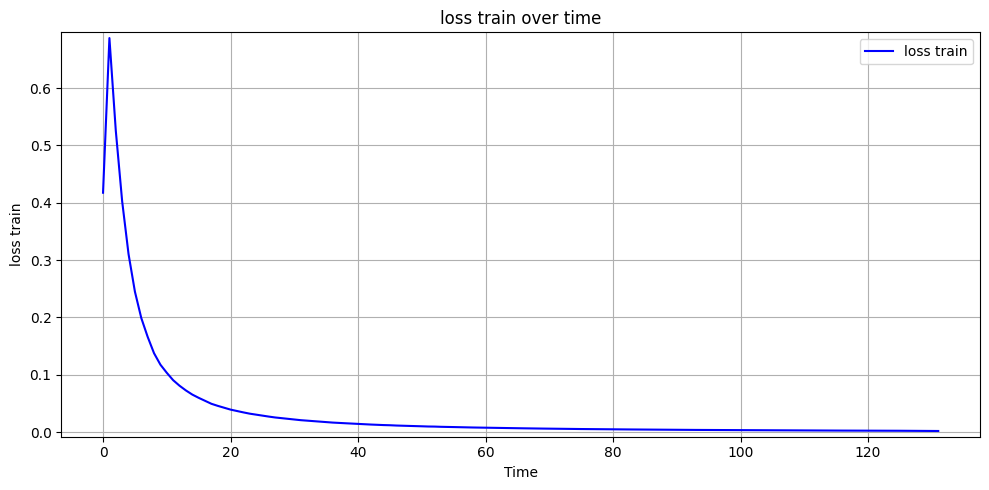

In [ ]:
visualize_data('loss train', './result/train_loss.txt')

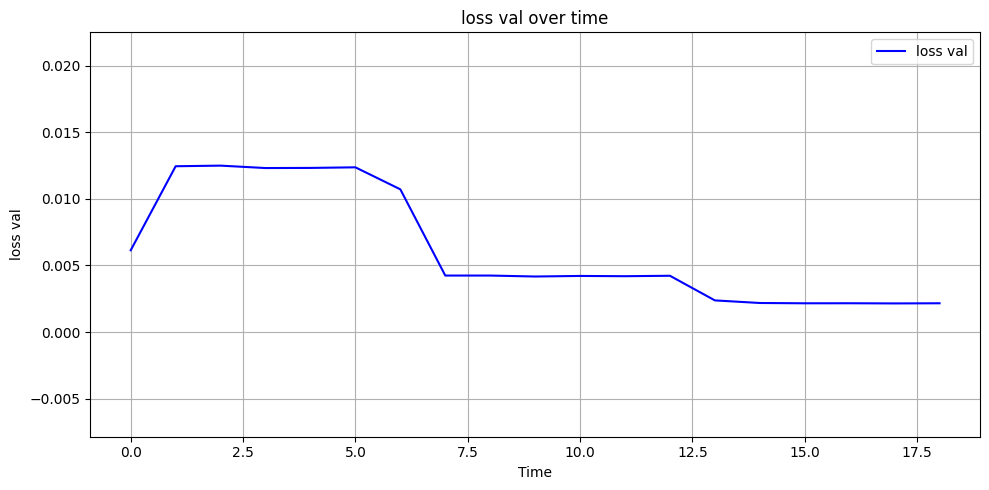

In [ ]:
visualize_data('loss val', './result/valid_loss.txt')

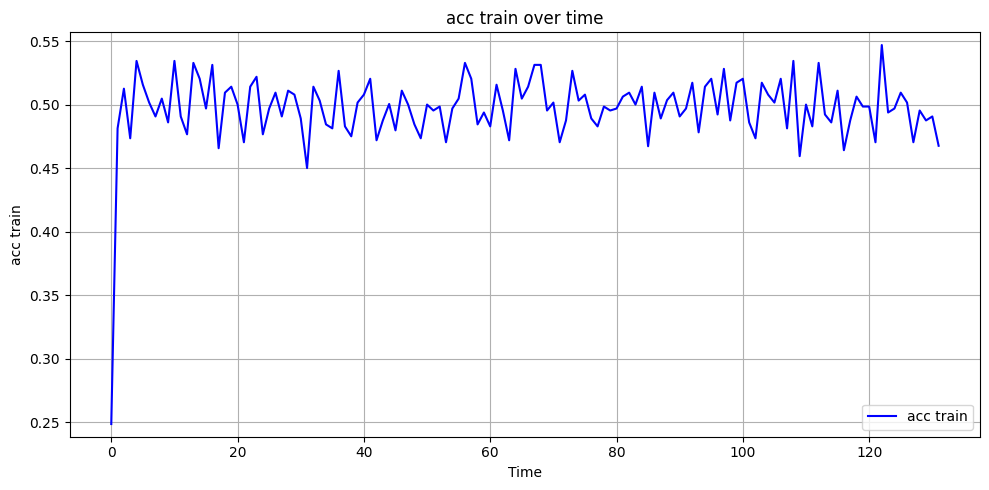

In [ ]:
visualize_data('acc train', './result/train_acc.txt')

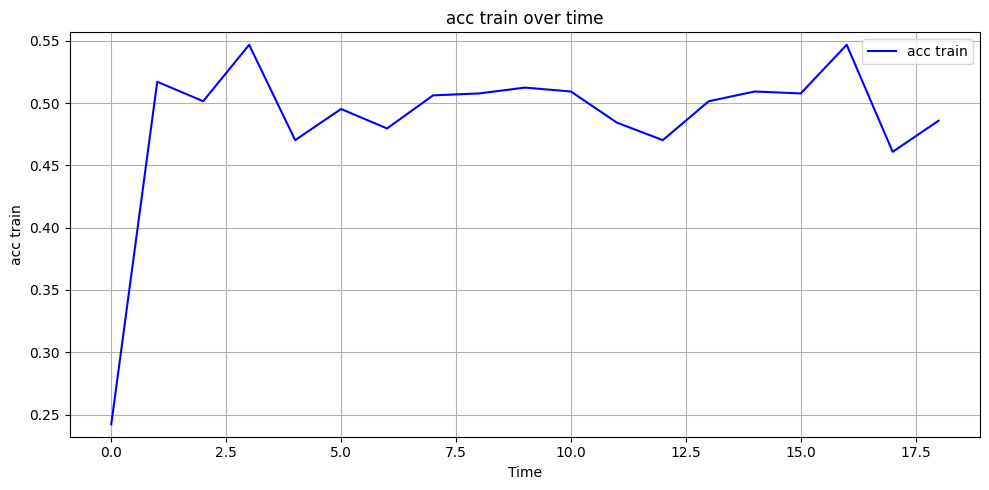

In [ ]:
visualize_data('acc train', './result/valid_acc.txt')

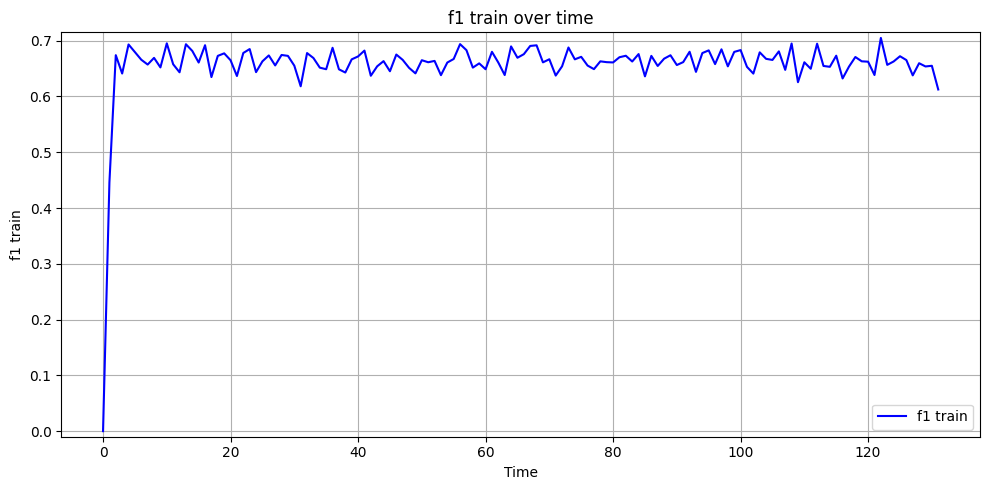

In [ ]:
visualize_data('f1 train', './result/train_f1.txt')

In [ ]:
def evaluate(model, loss_fn, dl):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    with torch.no_grad():
        for batch in dl:
            src = batch['input_ids'].to(DEVICE)
            trg_class = batch['label'].to(DEVICE)

            predicted_class, logits = model(src)
            loss = loss_fn(logits, trg_class)
            total_loss += loss.item()

            all_preds.extend(predicted_class.cpu().numpy())
            all_targets.extend(trg_class.cpu().numpy())

    # Compute final metrics
    final_metrics = eval_metrics(
        batch_loss=total_loss / len(dl),
        batch_y_true=all_targets,
        batch_y_pred=all_preds
    )

    print("\n=== Test Set Evaluation ===")
    print(f"Loss     : {final_metrics['loss']:.4f}")
    print(f"Accuracy : {final_metrics['accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall   : {final_metrics['recall']:.4f}")
    print(f"F1 Score : {final_metrics['f1']:.4f}")

    return final_metrics

evaluate(model, loss_fn, test_dl)


=== Test Set Evaluation ===
Loss     : nan
Accuracy : 0.4996
Precision: 0.4996
Recall   : 1.0000
F1 Score : 0.6663


{'loss': nan,
 'accuracy': 0.4995625546806649,
 'precision': 0.4995625546806649,
 'recall': 1.0,
 'f1': 0.6662777129521587}